# Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import Isomap
import pickle

%matplotlib inline
%matplotlib notebook

Using matplotlib backend: <object object at 0x000002126414A960>


# Dataset Analysis

In [4]:
# Load the dataset
df = pd.read_csv('csv/train_data.csv')

# Unneeded
df = df.drop(columns=['Unnamed: 0'])
df = df.drop_duplicates()

# Labeled subset (for training the supervised model)
df_labeled = df[df['SurvivalTime'].notna()]

Check for dataset metrics

In [ ]:
# Pandas profiler
profile = ProfileReport(df)
profile.to_notebook_iframe()

# Data Preprocessing

In [5]:
# TEST CELL

from statsmodels.multivariate.pca import PCA as PCA_sm

data = df.drop(columns=['SurvivalTime', 'Censored'])

# PCA
pca = PCA_sm(data, missing='fill-em', ncomp=5, standardize=False, normalize=False, demean=False)

# Convert to dataframe
df_pca = pd.DataFrame(pca.transformed_data, columns=data.columns)
df_pca.to_csv('csv/df_pca.csv', index=False)
pca.factors.to_csv('csv/pca_factors.csv', index=False)

In [6]:
from statsmodels.multivariate.pca import PCA as PCA_sm

# Wrapper class for PCA
class PCA_sm_wrapper:

    def __init__(self, ncomp=None, standardize=True, demean=True, normalize=True, gls=False, weights=None, method='svd', missing=None, tol=5e-08, max_iter=1000, tol_em=5e-08, max_em_iter=100, svd_full_matrices=False):
        self.ncomp = ncomp
        self.standardize = standardize
        self.demean = demean
        self.normalize = normalize
        self.gls = gls
        self.weights = weights
        self.method = method
        self.missing = missing
        self.tol = tol
        self.max_iter = max_iter
        self.tol_em = tol_em
        self.max_em_iter = max_em_iter
        self.svd_full_matrices = svd_full_matrices


    def fit(self, X, y=None):
        self.pca = PCA_sm(X, ncomp=self.ncomp, standardize=self.standardize, demean=self.demean, normalize=self.normalize, gls=self.gls, weights=self.weights, method=self.method, missing=self.missing, tol=self.tol, max_iter=self.max_iter, tol_em=self.tol_em, max_em_iter=self.max_em_iter, svd_full_matrices=self.svd_full_matrices)
        return self.pca.transformed_data


    def transform(self, X):
        self.pca = PCA_sm(X, ncomp=self.ncomp, standardize=self.standardize, demean=self.demean, normalize=self.normalize, gls=self.gls, weights=self.weights, method=self.method, missing=self.missing, tol=self.tol, max_iter=self.max_iter, tol_em=self.tol_em, max_em_iter=self.max_em_iter, svd_full_matrices=self.svd_full_matrices)
        return self.pca.transformed_data


    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [7]:
preprocessors = []

# For now there is only one preprocessor, but we can add more later to try different things
numerical_features = ['Age']
categorical_features = ['Gender', 'Stage', 'GeneticRisk', 'TreatmentType', 'ComorbidityIndex', 'TreatmentResponse']

# Preprocessors for missing values
numeric_inputers = [('simpleimputer', SimpleImputer(strategy='mean')), ('iterativeimputer', IterativeImputer()), ('knnimputer', KNNImputer())]

categorical_inputers = [('simpleimputer', SimpleImputer(strategy='most_frequent')), ('iterativeimputer', IterativeImputer()), ('knnimputer', KNNImputer())]


# Create multiple combinations of preprocessors
for numeric_imputer, categorical_inputer in zip(numeric_inputers, categorical_inputers):

    numeric_transformer = Pipeline(steps=[numeric_imputer,
                                          ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[categorical_inputer,
                                              ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_features),
                                                       ('cat', categorical_transformer, categorical_features)])

    preprocessors.append(preprocessor)


# This preprocessors uses the PCA's built-in imputation and scaling
preprocessor_smpca = Pipeline(steps=[('smpca', PCA_sm_wrapper(missing='fill-em', ncomp=5))])
preprocessors.append(preprocessor_smpca)

# Supervised Learning

In [8]:
# This method uses only the labeled subset to train the model
supervised_pipelines = {}   # Dictionary of pipelines (model_name: list of pipelines)

models = [('LinearRegression', LinearRegression()), ('Ridge', Ridge()), ('KNeighborsRegressor', KNeighborsRegressor()), ('DecisionTreeRegressor', DecisionTreeRegressor()), ('RandomForestRegressor', RandomForestRegressor()), ('SVR', SVR())]

# Initialize pipeline list for each type model
for model_name, model in models:
    supervised_pipelines[model_name] = []


# Create multiple combinations of preprocessors and models
for preprocessor in preprocessors:
    for model_name, model in models:
        supervised_pipelines[model_name].append(Pipeline(steps=[('preprocessor', preprocessor),
                                                                    ('model', model)]))


# Train your model on the training data
def train_model(model_name, X_train, y_train):
    model = supervised_pipelines[model_name]
    model.fit(X_train, y_train)
    return model

def predict(model_name, X):
    model = supervised_pipelines[model_name]
    return model.predict(X)

# Train all models
def train_all_models(X_train, y_train):
    for model_name in supervised_pipelines:
        train_model(model_name, X_train, y_train)


# Unsupervised Learning

In [23]:
features = df.drop(columns=['SurvivalTime', 'Censored'])

# Choose the number of clusters (K)
k = 5

# Apply K-Means
kmeans = KMeans(n_clusters=k)

# Visualize clusters using PCA
pca = PCA(n_components=5)

# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor_smpca),
                           ('pca', pca),
                           ('clustering', kmeans)])

# Fit pipeline to data
pipeline.fit(features)


# Clustering on labeled data
# ...
"""
# Assign clusters to unlabeled data
unlabeled_features = unlabeled_df.drop(['SurvivalTime', 'Censored'], axis=1)
unlabeled_clusters = kmeans.predict(unlabeled_features)

# Merge labeled and pseudo-labeled data
unlabeled_df['Cluster'] = unlabeled_clusters
merged_df = pd.concat([labeled_df, unlabeled_df], ignore_index=True)

# Train a supervised model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression  # Example model

X = merged_df.drop(['SurvivalTime', 'Censored'], axis=1)
y = merged_df['SurvivalTime']

# Split the merged data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a supervised model using the merged data
model = LinearRegression()  # Example model, replace with your choice
model.fit(X_train, y_train)

# Evaluate on validation set
# ...
"""

"\n# Assign clusters to unlabeled data\nunlabeled_features = unlabeled_df.drop(['SurvivalTime', 'Censored'], axis=1)\nunlabeled_clusters = kmeans.predict(unlabeled_features)\n\n# Merge labeled and pseudo-labeled data\nunlabeled_df['Cluster'] = unlabeled_clusters\nmerged_df = pd.concat([labeled_df, unlabeled_df], ignore_index=True)\n\n# Train a supervised model\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.linear_model import LinearRegression  # Example model\n\nX = merged_df.drop(['SurvivalTime', 'Censored'], axis=1)\ny = merged_df['SurvivalTime']\n\n# Split the merged data\nX_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Train a supervised model using the merged data\nmodel = LinearRegression()  # Example model, replace with your choice\nmodel.fit(X_train, y_train)\n\n# Evaluate on validation set\n# ...\n"

# Training and Evaluation

In [61]:
censored = df['Censored']

def cMSE(y_hat, y, c):
  err = y-y_hat
  err = (1-c)*err**2 + c*np.maximum(0,err)**2
  return np.sum(err)/err.shape[0]



def calc_fold(pipeline, X, y, train_ix, test_ix):
    """return regression error for train and test"""
    pipeline.fit(X.iloc[train_ix, :], y.iloc[train_ix])

    training_err = cMSE(pipeline.predict(X.iloc[train_ix, :]), y.iloc[train_ix], censored.iloc[train_ix])
    test_err = cMSE(pipeline.predict(X.iloc[test_ix, :]), y.iloc[test_ix], censored.iloc[test_ix])
    
    return training_err, test_err

def calc_test_error(pipeline, X_train, y_train, X_test, y_test):
    """return regression error for train and test"""
    pipeline.fit(X_train, y_train)

    test_err = cMSE(pipeline.predict(X_test), y_test, censored)
    
    return test_err

In [63]:
X_labeled = df_labeled.drop(columns=['SurvivalTime', 'Censored'])

y_labeled = df_labeled['SurvivalTime']

X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

folds = 5
kf = KFold(n_splits = folds)
lowest_val_err = 100000
errs={}
best_model_name = ''

for model_name in supervised_pipelines:  # for each set of pipelines (that use the same model)

    errs[model_name] = []

    for pipeline_number, pipeline in enumerate(supervised_pipelines[model_name]):    # for each pipeline in the set
      
        tr_err = va_err = 0
            
        for tr_ix, va_ix in kf.split(y_train, y_train):
            r, v = calc_fold(pipeline, X_train, y_train, tr_ix, va_ix)  # (r = training error, v = validation error) for current pipeline
            tr_err += r
            va_err += v

        tr_err = tr_err/folds
        va_err = va_err/folds

        # Print errors with 4 decimal places
        print(f"{model_name} {pipeline_number}; Training Error: {tr_err:.4f}; Validation Error: {va_err:.4f}")
        errs[model_name].append((tr_err, va_err))
            
        if(va_err < lowest_val_err):
            lowest_val_err = va_err
            best_model_name = model_name + " " + str(pipeline_number)

    print("-----------------------------------------------")

test_error = calc_test_error(pipeline, X_train, y_train, X_test, y_test) 
print(f"Best model: {best_model_name}, with test error: {test_error:.4f}")

LinearRegression 0; Training Error: 0.4318; Validation Error: 0.0996
LinearRegression 1; Training Error: 0.4313; Validation Error: 0.0946
LinearRegression 2; Training Error: 0.4285; Validation Error: 0.1033
LinearRegression 3; Training Error: 0.4324; Validation Error: 0.0931
-----------------------------------------------
Ridge 0; Training Error: 0.4321; Validation Error: 0.0996
Ridge 1; Training Error: 0.4315; Validation Error: 0.0946
Ridge 2; Training Error: 0.4287; Validation Error: 0.1033
Ridge 3; Training Error: 0.4325; Validation Error: 0.0932
-----------------------------------------------
KNeighborsRegressor 0; Training Error: 0.3804; Validation Error: 0.1241
KNeighborsRegressor 1; Training Error: 0.3838; Validation Error: 0.1296
KNeighborsRegressor 2; Training Error: 0.4029; Validation Error: 0.1469
KNeighborsRegressor 3; Training Error: 0.3823; Validation Error: 0.1354
-----------------------------------------------
DecisionTreeRegressor 0; Training Error: 0.0269; Validation 

LinearRegression
Ridge
KNeighborsRegressor
DecisionTreeRegressor
RandomForestRegressor
SVR


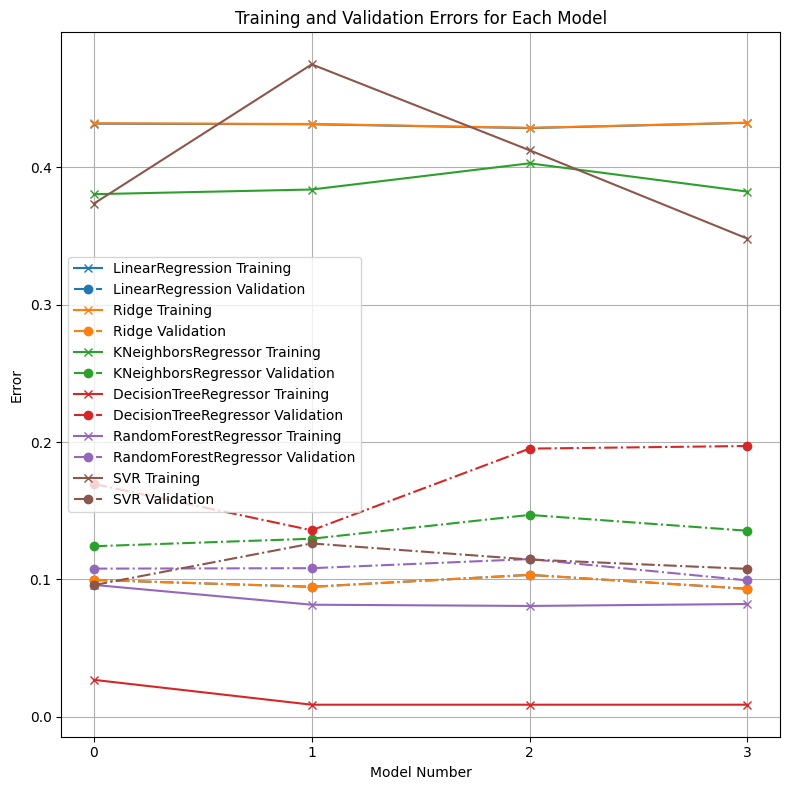

In [64]:
plt.figure(figsize=(8, 8), frameon=True)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # add more colors if needed


for (model_name, err_values), color in zip(errs.items(), colors):
    print(model_name)
    tr_errors, va_errors = zip(*err_values)
    plt.plot(range(0, len(tr_errors)), tr_errors, marker='x', color=color, label=f'{model_name} Training')
    plt.plot(range(0, len(va_errors)), va_errors, marker='o', linestyle='-.', color=color, label=f'{model_name} Validation')


plt.xlabel('Model Number')
plt.ylabel('Error')
plt.xticks(np.arange(0, len(preprocessors), step=1))
plt.title('Training and Validation Errors for Each Model')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Save Model

In [58]:
best_model = None

with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Submission Prediction

In [ ]:
best_model.fit(X_train, y_train)    # Be sure to use the best model on the appropriate data

In [57]:
final_test_dataset = pd.read_csv('csv/test_data.csv').drop(columns=['id'])
submission_pred = best_model.predict(final_test_dataset)

In [54]:
submission_pred_df = pd.DataFrame(submission_pred, columns=['TARGET'])
submission_pred_df.insert(0, 'id', range(0, len(submission_pred_df)))
submission_pred_df.to_csv('submission_pred.csv', index=False)